In [1]:
import torch
from fastai.vision.all import *
from fastai.torch_core import default_device

default_device = 1

from config import Config
from create_data_loaders import create_data_loaders
from helper_functions import dataset_info, convert_label

defaults.device = 'cuda:1'
torch.cuda.set_device(1)

config = Config(batch_size=32)


# Train

In [2]:
for crossfold_index in range(config.n_splits):
    dls = create_data_loaders(config, crossfold_index=crossfold_index)
    dataset_info(dls)
    learn = cnn_learner(dls, resnet50, metrics=[accuracy, F1Score()], model_dir=config.trained_model_dir)
    learn.fine_tune(5,base_lr=5e-3, cbs=[SaveModelCallback(monitor='f1_score', min_delta=0.01, fname=f'model_{crossfold_index}')])


Training images: 3450
Validation images: 1121


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.469917,0.696001,0.799286,0.539877,00:39


Better model found at epoch 0 with f1_score value: 0.5398773006134969.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.172546,0.923723,0.818020,0.556522,00:45
1,0.165526,0.379899,0.874219,0.704403,00:44
2,0.074788,0.479659,0.863515,0.657718,00:44
3,0.041530,0.523081,0.873327,0.713710,00:45
4,0.020416,0.720588,0.856378,0.628176,00:45


Better model found at epoch 0 with f1_score value: 0.5565217391304348.
Better model found at epoch 1 with f1_score value: 0.7044025157232704.
Training images: 3531
Validation images: 1040


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.523357,0.350750,0.855769,0.642857,00:37


Better model found at epoch 0 with f1_score value: 0.6428571428571429.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.209228,0.341297,0.906731,0.722063,00:45
1,0.139573,0.474652,0.849038,0.495177,00:45
2,0.063314,0.322001,0.898077,0.697143,00:45
3,0.042252,0.403965,0.900000,0.721925,00:45
4,0.017984,0.370837,0.900000,0.707865,00:45


Better model found at epoch 0 with f1_score value: 0.7220630372492837.
Training images: 3339
Validation images: 1232


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.554635,0.503554,0.852273,0.653992,00:36


Better model found at epoch 0 with f1_score value: 0.6539923954372623.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.205380,0.320946,0.886364,0.750000,00:44
1,0.153068,0.258048,0.909903,0.786127,00:44
2,0.098335,0.255295,0.923701,0.829710,00:44
3,0.039074,0.276072,0.910714,0.778226,00:44
4,0.018696,0.288803,0.910714,0.783465,00:44


Better model found at epoch 0 with f1_score value: 0.7500000000000001.
Better model found at epoch 1 with f1_score value: 0.7861271676300577.
Better model found at epoch 2 with f1_score value: 0.8297101449275363.
Training images: 3393
Validation images: 1178


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.470565,0.406925,0.849745,0.535433,00:37


Better model found at epoch 0 with f1_score value: 0.5354330708661418.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.213688,0.247277,0.936333,0.733096,00:44
1,0.128718,0.322426,0.934635,0.700389,00:44
2,0.080047,0.248999,0.930390,0.735484,00:44
3,0.027123,0.319627,0.939728,0.749117,00:44
4,0.010828,0.341578,0.939728,0.756014,00:44


Better model found at epoch 0 with f1_score value: 0.7330960854092526.
Better model found at epoch 3 with f1_score value: 0.7491166077738516.


# Validate

In [113]:
# create learners
dfs = []
for crossfold_index in range(config.n_splits):
    dls = create_data_loaders(config, crossfold_index=crossfold_index)
    learn = cnn_learner(dls, resnet50, metrics=[accuracy, F1Score()], model_dir=config.trained_model_dir)
    learn.load(f'model_{crossfold_index}')
    dl = dls[1].new(shuffle=False, drop_last=False)
    df = dl.items
    df = df[df.is_valid == True]
    preds, _, y_pred, loss = learn.get_preds(dl=dl, with_input=False, with_decoded=True, with_loss=True, act=None)
    df['scores'] = preds[:,0].numpy()
    df['loss'] = loss
    dfs.append(df)

df = pd.concat(dfs)
df

C:\Users\jvdputte\Miniconda3\envs\kidneystone\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


C:\Users\jvdputte\Miniconda3\envs\kidneystone\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


C:\Users\jvdputte\Miniconda3\envs\kidneystone\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


C:\Users\jvdputte\Miniconda3\envs\kidneystone\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


,name,labels,video_name,is_valid,scores,loss
70,0009/0001.png,calcium,0009,True,0.997457,0.002546
71,0009/0031.png,calcium,0009,True,0.998970,0.001030
72,0009/0061.png,calcium,0009,True,0.999165,0.000835
73,0009/0091.png,calcium,0009,True,0.995203,0.004809
74,0009/0121.png,calcium,0009,True,0.997680,0.002323
...,...,...,...,...,...,...
4439,0456/0361.png,calcium,0456,True,0.998406,0.001596
4440,0456/0391.png,calcium,0456,True,0.999696,0.000305
4441,0456/0421.png,calcium,0456,True,0.999874,0.000126
4442,0456/0451.png,calcium,0456,True,0.999371,0.000630


In [173]:
from sklearn.metrics import confusion_matrix
import pdb

def invert_pred(pred: str):
    return 'calcium' if pred == 'non-calcium' else 'non-calcium'

class Interpreter():
    
    def __init__(self, df, vocab, threshold=0.5):
        self.df = df
        self.vocab = vocab
        self.threshold = threshold
        self.cm = self.get_confusion_matrix()
        self.vid_df = self.get_vid_df()
        self.vid_cm = self.get_confusion_matrix(use_vid_df=True)
        
    def get_vid_df(self):
        vids = list(set(df['video_name']))
        scores = []
        labels = []
        preds = []
        losses = []
        for vid in vids:
            rows = df[df['video_name'] == vid]
            labels.append(rows.iloc[0].labels)
            score = rows.scores.sum()/len(rows)
            scores.append(score)
            losses.append(rows.loss.sum()/len(rows))
            preds.append('calcium' if (score > self.threshold) else 'non-calcium')
            
        
        return pd.DataFrame({'vid_name': vids, 'labels': labels, 'preds': preds, 'scores': scores, 'losses': losses})
            
        
    def get_confusion_matrix(self, use_vid_df=False):
        df = self.vid_df if use_vid_df else self.df
        y = df.labels
        y_pred = ['calcium' if (item > self.threshold) else 'non-calcium' for item in df.scores]
        return confusion_matrix(y, y_pred)
    

    def plot_confusion_matrix(self, title='Confusion matrix', cmap='Blues', use_vid_df=False):
                              
        cm = self.vid_cm if use_vid_df else self.cm
        fig = plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(self.vocab))
        plt.xticks(tick_marks, self.vocab, rotation=90)
        plt.yticks(tick_marks, self.vocab, rotation=0)
        
        thresh = cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            coeff = f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white"
                     if cm[i, j] > thresh else "black")
        
        ax = fig.gca()
        ax.set_ylim(len(self.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)
        
    def classification_report(self, use_vid_df=False):
        cm = self.vid_cm if use_vid_df else self.cm
        tp, fn, fp, tn = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fn + fp)
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        
        width = 50
        tmp = 'video' if use_vid_df else 'image'
        print(f'---------{tmp}-----------')
        print(f'accuracy: {accuracy:.3f} ({tp + tn}/{tp + tn + fn + fp})')
        print(f'sensitivity: {sensitivity:.3f} ({tp}/{tp + fn})')
        print(f'specificity: {specificity:.3f}({tn}/{tn + fp})')
        print('--------------------------')
        
        
    def get_wrong_vids(self):
        df = self.vid_df[self.vid_df.labels != self.vid_df.preds]
        
        return df.sort_values(by=['losses'], ascending=False)
        

---------image-----------
accuracy: 0.896 (4094/4571)
sensitivity: 0.922 (3389/3676)
specificity: 0.788(705/895)
--------------------------


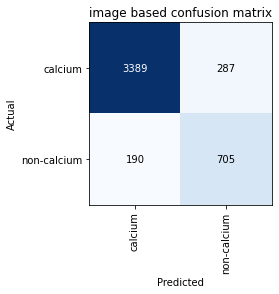

In [178]:
interp = Interpreter(df, dl.vocab, threshold=.8)
interp.plot_confusion_matrix(title='image based confusion matrix')
interp.classification_report()

---------video-----------
accuracy: 0.914 (297/325)
sensitivity: 0.914 (243/266)
specificity: 0.915(54/59)
--------------------------


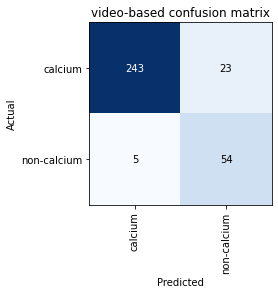

In [179]:
interp.plot_confusion_matrix(use_vid_df=True, title='video-based confusion matrix')
interp.classification_report(use_vid_df=True)

In [182]:
interp.get_wrong_vids()

,vid_name,labels,preds,scores,losses
96,0322,non-calcium,calcium,0.999156,8.294327
112,0168,non-calcium,calcium,0.997251,6.884587
221,0125,non-calcium,calcium,0.998650,6.829827
305,0225,calcium,non-calcium,0.213057,2.694905
48,0154,non-calcium,calcium,0.893636,2.688368
280,0323,non-calcium,calcium,0.811212,2.130304
213,0335,calcium,non-calcium,0.341668,2.004898
116,0263,calcium,non-calcium,0.504306,1.912515
273,0295,calcium,non-calcium,0.410214,1.699352
231,0425,calcium,non-calcium,0.348157,1.537317
